In [2]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install funcy
import funcy
from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc
import pickle
from torchsummary import summary

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable


In [3]:
start_date = '1980-01-01'

In [4]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
# returns_df = returns_df.dropna(axis=0,thresh=500).dropna(axis=1,thresh=500)
equity_idx = returns_df.columns
date_idx = returns_df.index
returns_df = returns_df.clip(returns_df.quantile(0.01,axis=1),returns_df.quantile(0.99,axis=1),axis=0)
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.004620,-0.160989,0.084211,-0.222720,-0.456986,-0.093750,-0.115145,NaN,NaN


In [5]:
feat_comb_df = pd.read_csv('features_full_final.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME        AC        AT       ATO      BEME      BETA  \
tic   rdq                                                                      
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-02-28  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-03-31  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-04-30  0.529462       NaN   146.767       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
ZZ    2012-10-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.503049   
      2012-11-30  5.840417  0.377852   971.509  0.888069 -0.316438  0.503035   
      2012-12-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.500307   
      2013-01-31  4.440987  0.489857  1005.345  1.081163 -0.253677  0.501021   
      2013-02-28  4.440987  0.489857  1005.345  1.081163 -0.253677  0.500922   

                         C  CF      CF2P       CTO  ...  REL2HIGH  RESID_VAR  \
tic   rdq                                           ...                        
0081A 1996-12-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-01-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-02-28  0.011328 NaN       NaN       NaN  ...       NaN   1.896184   
      1997-03-31  0.011328 NaN       NaN       NaN  ...       NaN   2.542292   
      1997-04-30  0.014431 NaN       NaN       NaN  ...       NaN   2.653953   
...                    ...  ..       ...       ...  ...       ...        ...   
ZZ    2012-10-31  0.091438 NaN -0.015174  0.549053  ...  0.910204   1.851362   
      2012-11-30  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.619041   
      2012-12-31  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.598993   
      2013-01-31  0.127473 NaN  0.042809  0.614895  ...  0.881633   0.542592   
      2013-02-28  0.127473 NaN  0.042809  0.614895  ...  0.889796   0.429795   

                       RNA       ROA       ROE       S2P     SGA2S   ST_REV  \
tic   rdq                                                                     
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-02-28       NaN       NaN       NaN       NaN       NaN   1.5583   
      1997-03-31       NaN       NaN       NaN       NaN       NaN  10.7738   
      1997-04-30       NaN       NaN       NaN       NaN       NaN  -2.7778   
...                    ...       ...       ...       ...       ...      ...   
ZZ    2012-10-31  0.118627 -0.009920  0.167075  7.568810  0.818410  36.2500   
      2012-11-30  0.118627 -0.009920  0.167075  7.568810  0.818410   2.2936   
      2012-12-31  0.118627 -0.009920  0.167075  7.568810  0.818410  -2.6906   
      2013-01-31  0.167337  0.002145 -0.024645  5.954049  0.798554   0.0000   
      2013-02-28  0.167337  0.002145 -0.024645  5.954049  0.798554  -0.4608   

                       SUV  VARIANCE  
tic   rdq                             
0081A 1996-12-31       NaN       NaN  
      1997-01-31       NaN       NaN  
      1997-02-28       NaN  4.225542  
      1997-03-31       NaN  6.975184  
      1997-04-30       NaN  7.456677  
...                    ...       ...  
ZZ    2012-10-31  0.669890  4.256721  
      2012-11-30 -0.125130  0.458271  
      2012-12-31  0.062727  0.420686  
      2013-01-31 -1.501970  0.311550  
      2013-02-28 -0.227316  0.230933  

[3692558 rows x 45 columns]

In [6]:
MIN_AVAILABLE_FEATURES = feat_comb_df.shape[1]//2

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) <= date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)
    
del feat_comb_df
gc.collect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [09:20<00:00,  1.10s/it]


0

# Read Data Files

In [253]:
data_dict = {
#     'LSTM_to_Linear_1': 'lstm_to_linear_1.data',
#     'LSTM_to_Linear_2': 'lstm_to_linear_2.data',
#     'LSTM_to_Linear_4': 'lstm_to_linear_4.data',
#     'LSTM_only_1_highreg': 'lstm_only_1_highreg.data',
#     'LSTM_only_1_lowreg': 'lstm_only_1_lowreg.data',
        'LSTM 4 Layer2': 'lstm_only_2_lowreg.data',
#     'LSTM 6 Layer2': 'lstm6_only_2_lowreg.data',
#     'LSTM 8 Layer2': 'lstm8_only_2_lowreg.data',
      'Linear16 to LSTM2 Batchnorm': 'linear16_lstm4_2_batchnorm_lowreg.data',
      'Linear16 to LSTM1 Batchnorm': 'linear16_lstm4_1_batchnorm_lowreg.data',
      'Linear16 to LSTM1': 'linear16_lstm4_1_lowreg.data',
#     'Baseline 4': 'vanilla.data',
#     'Linear to LSTM': 'linear_to_lstm_prelim.data'
#     'Baseline 8': 'vanilla8.data',
#     'Baseline 12': 'vanilla12.data',
}

for k,v in data_dict.items():
    with open(v, 'rb') as handle:
        data_dict[k] = pickle.load(handle)
        
    
    predicted_returns_lst = data_dict[k]['predicted_returns_lst']
    predicted_factors_lst = data_dict[k]['predicted_factors_lst']
    output_df_lst = data_dict[k]['output_df_lst']
    factors_df_lst = data_dict[k]['factors_df_lst']
    if 'y_macro_df_lst' in data_dict[k] :
        y_macro_df_lst = data_dict[k]['y_macro_df_lst']
    
    
    predicted_returns = predicted_returns_lst[0]
    for df in predicted_returns_lst[1:]:
        predicted_returns += df
    predicted_returns /= len(predicted_returns_lst)

    output_df = output_df_lst[0]
    for df in output_df_lst[1:]:
        output_df += df
    output_df /= len(output_df_lst)

    log_dict = {}


    # Predictive Stats:
    # Spearman Corr
    corr = predicted_returns.corrwith(returns_df.loc[predicted_returns.index,predicted_returns.columns],axis=1,method='spearman')
    log_dict['pred_spearman_corr'] = corr.mean()
    # R2
    numer = (returns_df.loc[predicted_returns.index,predicted_returns.columns]-predicted_returns)
    numer_mask = (~numer.isna()).astype(int)
    denom = returns_df.loc[predicted_returns.index,predicted_returns.columns] * numer_mask
    log_dict['pred_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

    # Attribution Stats:
    # Spearman Corr
    corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
    log_dict['total_spearman_corr'] = corr.mean()
    # R2
    numer = (returns_df.loc[output_df.index,output_df.columns]-output_df)
    numer_mask = (~numer.isna()).astype(int)
    denom = returns_df.loc[output_df.index,output_df.columns] * numer_mask
    log_dict['total_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

    # Trading Stats:
    train_pred_rank = predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)
    long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
    long_port = long_port.divide(long_port.sum(axis=1),axis=0)
    long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
    short_port = (train_pred_rank <= 0.1).astype(int)
    short_port = short_port.divide(short_port.sum(axis=1),axis=0)
    short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
    comb_port = long_port - short_port
    comb_port_returns = (comb_port*returns_df.loc[comb_port.index]).sum(axis=1)
    log_dict['long_short_SR'] = (comb_port_returns.mean()/comb_port_returns.std())*np.sqrt(12)
    log_dict['long_short_returns'] = comb_port_returns.mean()*12
    log_dict['long_short_SD'] = comb_port_returns.std()*np.sqrt(12)

    log_dict['long_SR'] = (long_port_returns.mean()/long_port_returns.std())*np.sqrt(12)
    log_dict['long_returns'] = long_port_returns.mean()*12
    log_dict['long_SD'] = long_port_returns.std()*np.sqrt(12)

    log_dict['short_SR'] = (short_port_returns.mean()/short_port_returns.std())*np.sqrt(12)
    log_dict['short_returns'] = short_port_returns.mean()*12
    log_dict['short_SD'] = short_port_returns.std()*np.sqrt(12)

    
    data_dict[k]['log_dict'] = log_dict
    data_dict[k]['predicted_returns'] = predicted_returns
    data_dict[k]['output_df'] = output_df
    data_dict[k]['train_pred_rank'] = train_pred_rank
    

# Visualizations

In [254]:
for k,v in data_dict.items():
    print(k)
    print(v['log_dict'])

LSTM 4 Layer2
{'pred_spearman_corr': 0.05076046531894062, 'pred_r2': 0.0007369647971807657, 'total_spearman_corr': 0.07987572286635836, 'total_r2': 0.019455623558096723, 'long_short_SR': 0.7098350823673815, 'long_short_returns': 0.10124844191229154, 'long_short_SD': 0.1426365707012062, 'long_SR': 0.5578022886285203, 'long_returns': 0.09361789864896924, 'long_SD': 0.16783347891804, 'short_SR': -0.030762167351491065, 'short_returns': -0.007630543263322341, 'short_SD': 0.248049598590864}
Linear16 to LSTM2 Batchnorm
{'pred_spearman_corr': 0.05628522399270053, 'pred_r2': 0.0007943075425290179, 'total_spearman_corr': 0.08610930241156399, 'total_r2': 0.02599906993630738, 'long_short_SR': 0.4723457242714958, 'long_short_returns': 0.08679568891957823, 'long_short_SD': 0.1837545773351589, 'long_SR': 0.5828471656622425, 'long_returns': 0.075280661935237, 'long_SD': 0.12916020934870912, 'short_SR': -0.04471462182368731, 'short_returns': -0.011515026984341214, 'short_SD': 0.25752262939281295}
Linea

Individual Model Plots:

In [255]:
k = 'Linear16 to LSTM1'

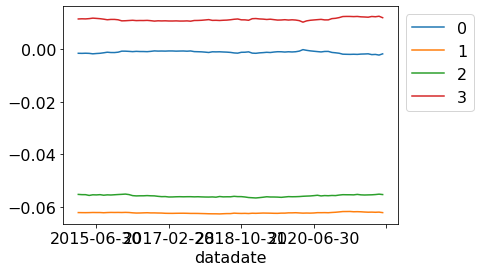

In [256]:
data_dict[k]['predicted_factors_lst'][0].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

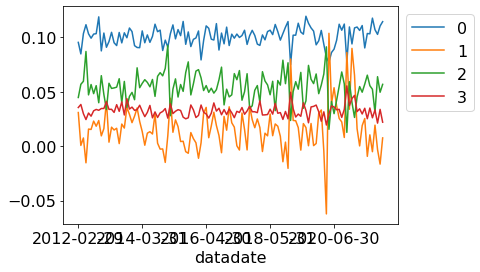

In [257]:
data_dict[k]['factors_df_lst'][3].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

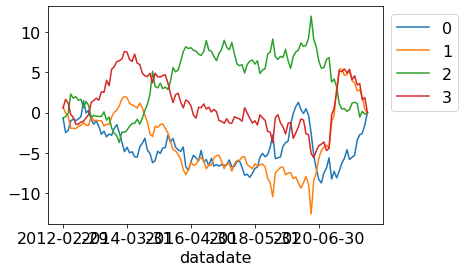

In [258]:
((data_dict[k]['factors_df_lst'][3] - data_dict[k]['factors_df_lst'][3].mean())/data_dict[k]['factors_df_lst'][3].std()).cumsum().plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

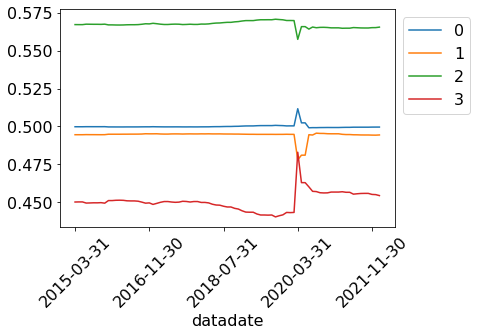

In [259]:
data_dict[k]['y_macro_df_lst'][4].loc['2015-03-31':].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.xticks(rotation = 45)
plt.show()

Combined plots:

In [260]:
def get_sharpes_by_decile(train_pred_dict, metric='sharpe', start_date=None, end_date=None):
    ranked_sharpes_dict = {}
    for name, train_pred in tqdm(train_pred_dict.items(),total=len(train_pred_dict)):
        train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=True)

        ranks = np.arange(0,1,.1)
        ranked_returns = []

        for r in ranks:
            port = ((train_pred_rank >= r) & (train_pred_rank < r+.1)).astype(int)
            port = port.divide(port.sum(axis=1),axis=0)
            port_returns = (port*returns_df.loc[port.index]).sum(axis=1)
            ranked_returns.append(port_returns)
            
        ranked_df = pd.concat(ranked_returns,axis=1)
        ranked_df.columns = ranks
        
        if start_date:
            ranked_df = ranked_df.loc[start_date:]
        if end_date:
            ranked_df = ranked_df.loc[:end_date]
        
        
        if metric == 'sharpe':
            ranked_sharpe = ranked_df.mean() / ranked_df.std() * np.sqrt(12)
            ranked_sharpes_dict[name] = ranked_sharpe
        elif metric == 'returns':
            ranked_sharpes_dict[name] = ranked_df.mean() * 12
        elif metric == 'volatility':
            ranked_sharpes_dict[name] = ranked_df.std() * np.sqrt(12)

    return ranked_sharpes_dict

In [261]:
prediction_dict = {}
for k,v in data_dict.items():
    prediction_dict[k] = v['predicted_returns']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]

Out of sample Sharpe Ratio (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM 4 Layer2,-0.274,-0.140,0.145,0.350,0.429,0.608,0.670,0.680,0.639,0.529
Linear16 to LSTM1,-0.422,0.029,0.127,0.373,0.373,0.437,0.596,0.525,0.528,0.510
Linear16 to LSTM1 Batchnorm,-0.471,-0.122,0.101,0.328,0.392,0.549,0.701,0.727,0.754,0.739
Linear16 to LSTM2 Batchnorm,-0.495,-0.246,0.181,0.419,0.548,0.639,0.640,0.686,0.752,0.686


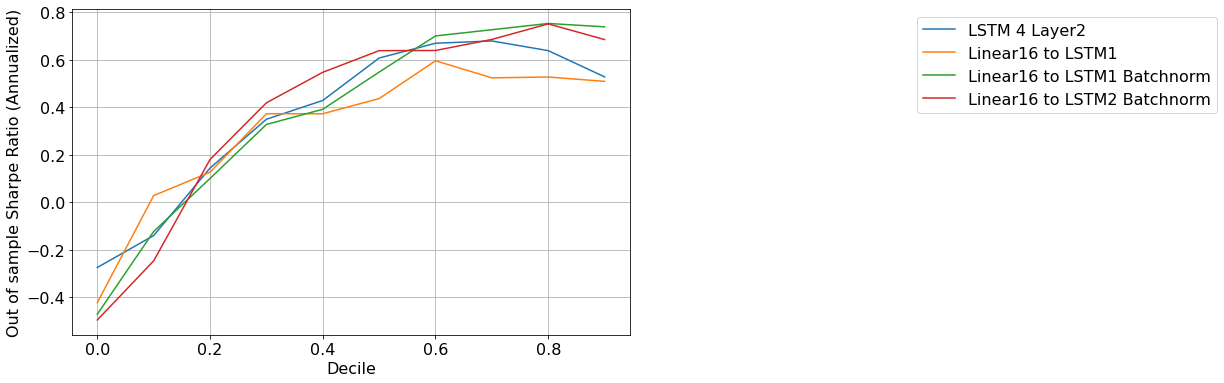

In [273]:
metric = 'sharpe'
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric)
ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,end_date='2019-12-31')
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,start_date='2019-12-31')
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]

Out of sample Returns (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM 4 Layer2,-0.052,-0.023,0.020,0.041,0.047,0.067,0.074,0.077,0.078,0.068
Linear16 to LSTM1,-0.060,0.004,0.015,0.047,0.048,0.056,0.078,0.068,0.071,0.070
Linear16 to LSTM1 Batchnorm,-0.086,-0.019,0.015,0.044,0.052,0.066,0.079,0.079,0.081,0.086
Linear16 to LSTM2 Batchnorm,-0.090,-0.040,0.028,0.058,0.071,0.076,0.074,0.074,0.079,0.066


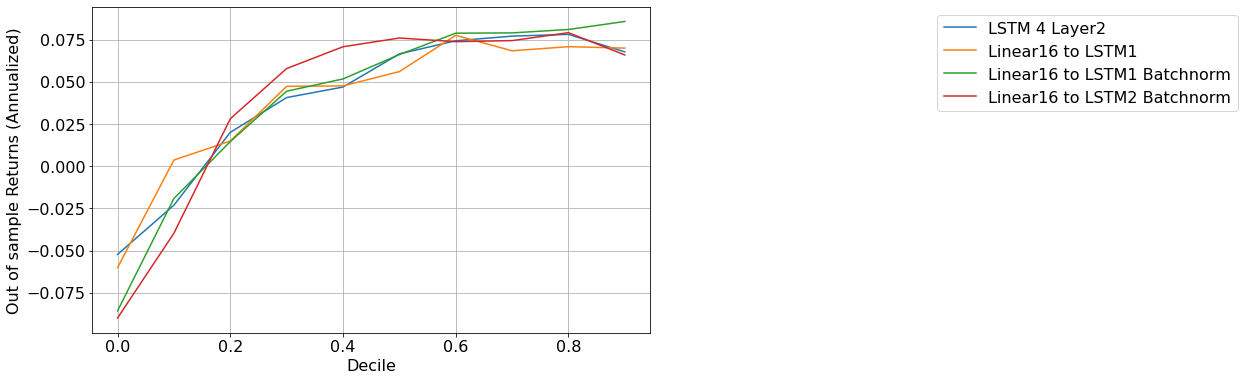

In [274]:
metric = 'returns'
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric)
ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,end_date='2019-12-31')
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,start_date='2019-12-31')

metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.31s/it]

Out of sample Volatility (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM 4 Layer2,0.191,0.166,0.139,0.116,0.109,0.109,0.111,0.113,0.122,0.128
Linear16 to LSTM1,0.143,0.127,0.117,0.127,0.127,0.128,0.130,0.130,0.134,0.137
Linear16 to LSTM1 Batchnorm,0.182,0.156,0.144,0.135,0.132,0.121,0.112,0.109,0.108,0.116
Linear16 to LSTM2 Batchnorm,0.182,0.161,0.155,0.138,0.129,0.119,0.115,0.108,0.105,0.096


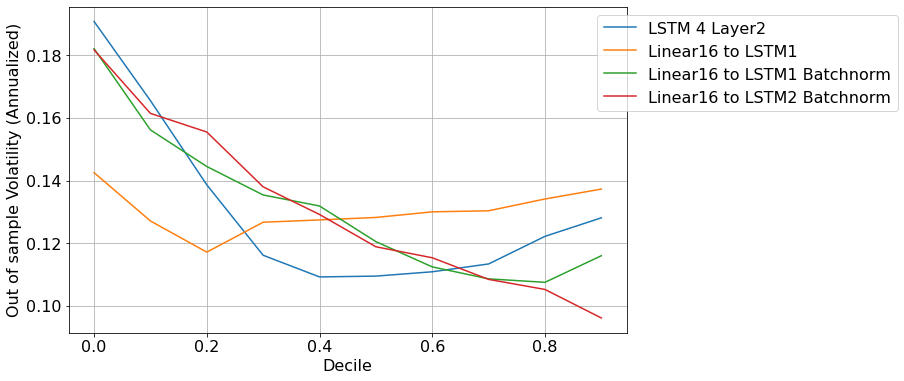

In [275]:
metric = 'volatility'
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric)
ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,end_date='2019-12-31')
# ranked_sharpes_dict = get_sharpes_by_decile(prediction_dict,metric=metric,start_date='2019-12-31')
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

Return plots

In [276]:
def plot_returns(train_pred_rank, port_type, label=""):
    long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
    long_port = long_port.divide(long_port.sum(axis=1),axis=0)
    short_port = (train_pred_rank <= 0.1).astype(int)
    short_port = short_port.divide(short_port.sum(axis=1),axis=0)
    if port_type=='long':
        long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
        ax = long_port_returns.cumsum().plot(label=label)
        print(f"{label} Long Annualized Return:",long_port_returns.mean()*12)
        print(f"{label} Long Annualized SD:",long_port_returns.std()*np.sqrt(12))
        print(f"{label} Long Annualized Sharpe:",(long_port_returns.mean()/long_port_returns.std())*np.sqrt(12))
    elif port_type=='short':
        short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
        ax = short_port_returns.cumsum().plot(label=label)
        print(f"{label} Short Annualized Return:",short_port_returns.mean()*12)
        print(f"{label} Short Annualized SD:",short_port_returns.std()*np.sqrt(12))
        print(f"{label} Short Annualized Sharpe:",(short_port_returns.mean()/short_port_returns.std())*np.sqrt(12))
    elif port_type=='long_short':
        full_port = long_port - short_port
        full_port_returns = (full_port*returns_df.loc[full_port.index]).sum(axis=1)
        ax = full_port_returns.cumsum().plot(label=label)
        print(f"{label} Long Short Annualized Return:",full_port_returns.mean()*12)
        print(f"{label} Long Short Annualized SD:",full_port_returns.std()*np.sqrt(12))
        print(f"{label} Long Short Annualized Sharpe:",(full_port_returns.mean()/full_port_returns.std())*np.sqrt(12))
    return ax

In [277]:
# plot_lst = [
#     'LSTM_only_1_highreg',
#     'LSTM_only_1_lowreg',
#     'LSTM_only_2_lowreg'
# ]
plot_lst = data_dict.keys()
plot_dict = {}
for k in plot_lst:
    plot_dict[k] = data_dict[k]['train_pred_rank'] 

LSTM 4 Layer2 Long Annualized Return: 0.09361789864896924
LSTM 4 Layer2 Long Annualized SD: 0.16783347891804
LSTM 4 Layer2 Long Annualized Sharpe: 0.5578022886285203
Linear16 to LSTM2 Batchnorm Long Annualized Return: 0.075280661935237
Linear16 to LSTM2 Batchnorm Long Annualized SD: 0.12916020934870912
Linear16 to LSTM2 Batchnorm Long Annualized Sharpe: 0.5828471656622425
Linear16 to LSTM1 Batchnorm Long Annualized Return: 0.08409070300315605
Linear16 to LSTM1 Batchnorm Long Annualized SD: 0.14692183437057044
Linear16 to LSTM1 Batchnorm Long Annualized Sharpe: 0.5723499394314672
Linear16 to LSTM1 Long Annualized Return: 0.1008564990214823
Linear16 to LSTM1 Long Annualized SD: 0.18546145581050313
Linear16 to LSTM1 Long Annualized Sharpe: 0.5438137999117902


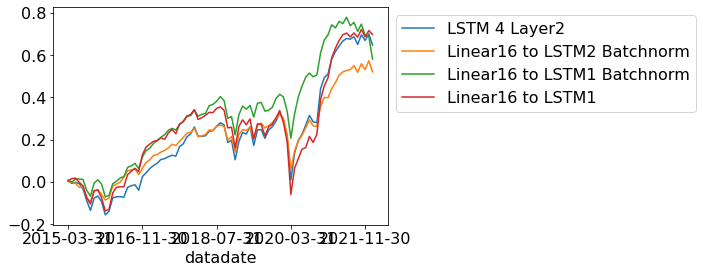

In [278]:
for k,v in plot_dict.items():
    ax = plot_returns(v,port_type='long',label=k)
plt.legend(bbox_to_anchor=(1.0,1))
plt.show()

LSTM 4 Layer2 Short Annualized Return: -0.007630543263322341
LSTM 4 Layer2 Short Annualized SD: 0.248049598590864
LSTM 4 Layer2 Short Annualized Sharpe: -0.030762167351491065
Linear16 to LSTM2 Batchnorm Short Annualized Return: -0.011515026984341214
Linear16 to LSTM2 Batchnorm Short Annualized SD: 0.25752262939281295
Linear16 to LSTM2 Batchnorm Short Annualized Sharpe: -0.04471462182368731
Linear16 to LSTM1 Batchnorm Short Annualized Return: 0.0055858711498522244
Linear16 to LSTM1 Batchnorm Short Annualized SD: 0.2497574860128314
Linear16 to LSTM1 Batchnorm Short Annualized Sharpe: 0.022365180075384197
Linear16 to LSTM1 Short Annualized Return: -0.002663478566573994
Linear16 to LSTM1 Short Annualized SD: 0.20210868496154558
Linear16 to LSTM1 Short Annualized Sharpe: -0.013178446869221695


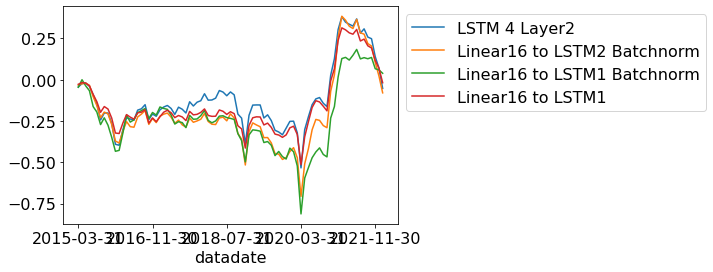

In [279]:
for k,v in plot_dict.items():
    plot_returns(v,port_type='short',label=k)
plt.legend(bbox_to_anchor=(1.0,1))
plt.show()

LSTM 4 Layer2 Long Short Annualized Return: 0.10124844191229154
LSTM 4 Layer2 Long Short Annualized SD: 0.1426365707012062
LSTM 4 Layer2 Long Short Annualized Sharpe: 0.7098350823673815
Linear16 to LSTM2 Batchnorm Long Short Annualized Return: 0.08679568891957823
Linear16 to LSTM2 Batchnorm Long Short Annualized SD: 0.1837545773351589
Linear16 to LSTM2 Batchnorm Long Short Annualized Sharpe: 0.4723457242714958
Linear16 to LSTM1 Batchnorm Long Short Annualized Return: 0.07850483185330384
Linear16 to LSTM1 Batchnorm Long Short Annualized SD: 0.16406847822826426
Linear16 to LSTM1 Batchnorm Long Short Annualized Sharpe: 0.4784882062725179
Linear16 to LSTM1 Long Short Annualized Return: 0.10351997758805631
Linear16 to LSTM1 Long Short Annualized SD: 0.12288221561119589
Linear16 to LSTM1 Long Short Annualized Sharpe: 0.8424325446376841


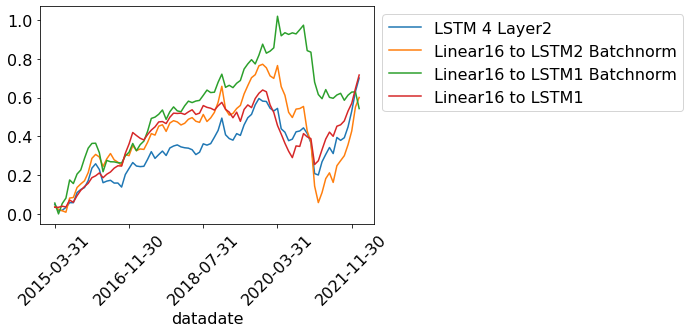

In [280]:
for k,v in plot_dict.items():
    plot_returns(v.loc[:],port_type='long_short',label=k)
    #:'2019-12-31'
plt.legend(bbox_to_anchor=(1.0,1))
plt.xticks(rotation = 45)
plt.show()